### Model (Without ResNet)
* Moderate downsampling
* Skip connections for concatenation
* RELU + Batch Norm
* No RELU after each block output
* Multi-scale feature extraction using ASPP similar network

In [14]:
import sys
import random
import os
import warnings

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from tqdm import tqdm
from itertools import chain

from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import models
from tensorflow.keras import callbacks
import glob

from PIL import Image
import glob

import tensorflow as tf
import time
import cv2

In [15]:
!which python3
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    print("Name:", gpu.name, "  Type:", gpu.device_type)

/home/tomzhouyuxing/anaconda3/bin/python3
Name: /physical_device:GPU:0   Type: GPU


In [16]:
# Set some parameters
IMG_WIDTH = 512
IMG_HEIGHT = 512
IMG_CHANNELS = 3
#TRAIN_PATH = './dataset/training/'
#TEST_PATH = './dataset/testing/'
TRAIN_NUM = 1700
TEST_NUM = 300
sample_dir = "../training/sample/"
mask_dir = "../training/mask/"
test_sample_dir = "../testing/sample/"
test_mask_dir = "../testing/mask/"


In [17]:
#Get the filenames of training and testing data
sample_ids = next(os.walk(sample_dir))[2]
test_sample_ids = next(os.walk(test_sample_dir))[2]
print(sample_ids[:10])
print(test_sample_ids[:10])

['01255.png', '00956.png', '00762.png', '00086.png', '00005.png', '01468.png', '01682.png', '00334.png', '00291.png', '00346.png']
['00086.png', '00005.png', '00291.png', '00184.png', '00046.png', '00038.png', '00170.png', '00224.png', '00203.png', '00264.png']


In [18]:
def conv_block(input_tensor, num_filters):
    '''
    Number of filters (num_filters) : the number of input and output channels.
        the block doesn't change output shape
    
    TO-DO
        set the the depth separable convolution's filter_num to different sizes
            and see how the parameters change.

    '''
    # 1x1 convolution to shrink input channels
    encoderONE = layers.Conv2D(int(num_filters/2), (1,1), padding = "same")(input_tensor)
    encoderONE = layers.BatchNormalization()(encoderONE)
    encoderONE = layers.Activation('relu')(encoderONE)
    
    #1x1 convolution
    encoderTWO = layers.Conv2D(int(num_filters/2), (1,1), padding = "same")(input_tensor)
    # 5x5 depthwise separable convolution stride 1 dilation_rate = 2
    encoderTWO = layers.SeparableConv2D(num_filters*2, (5,5), dilation_rate = 2, padding = "same")(encoderTWO)
    encoderTWO = layers.BatchNormalization()(encoderTWO)
    encoderTWO = layers.Activation('relu')(encoderTWO)
    
    #1x1 convolution
    encoderTHR = layers.Conv2D(int(num_filters/2), (1,1), padding = "same")(input_tensor)
    # 3x3 depthwise separable convolution stride 1 dilation_rate = 2
    encoderTHR = layers.SeparableConv2D(num_filters*2, (3,3), dilation_rate = 2, padding = "same")(encoderTHR)
    encoderTHR = layers.BatchNormalization()(encoderTHR)
    encoderTHR = layers.Activation('relu')(encoderTHR)
 
    encoderOUT = layers.concatenate([encoderTHR, encoderTWO, encoderONE], axis=-1)
    #Final 1x1 convolution with relu to make sure the output have the same channels as input
    encoderOUT = layers.Conv2D(num_filters, (1,1), padding = "same")(encoderOUT)
#     encoderOUT = layers.Activation("relu")(encoderOUT)

    return encoderOUT

def downsample_block(input_tensor, num_filters):
    
    #Store the input to this "max_pooling layer" for skip connections
    store_feature =  layers.Conv2D(int(num_filters/2), (1,1), padding = "same")(input_tensor)
    # 2x2 max_pooling with stride 2
    encoderONE = layers.MaxPooling2D((2, 2), strides=(2, 2))(input_tensor) #already have output dimension desired

    encoderTWO = layers.Conv2D(int(num_filters/4), (1,1), padding = "same")(input_tensor)
    # 5x5 depthwise separable convolution stride = 2
    encoderTWO = layers.ZeroPadding2D(padding=(2, 2))(encoderTWO) # zero-padding (2,2) to keep output dimension consistent
    encoderTWO = layers.SeparableConv2D(num_filters, (5,5), strides = 2)(encoderTWO)
    encoderTWO = layers.BatchNormalization()(encoderTWO)
    encoderTWO = layers.Activation('relu')(encoderTWO)
    
    encoderTHR = layers.Conv2D(int(num_filters/4), (1,1), padding = "same")(input_tensor)
    # 3x3 depthwise separable convolution stride = 2
    encoderTHR = layers.ZeroPadding2D(padding = (1,1))(encoderTHR) # zero-padding (1,1) to keep output dimension consistent
    encoderTHR = layers.SeparableConv2D(num_filters, (3,3), strides = 2)(encoderTHR)
    encoderTHR = layers.BatchNormalization()(encoderTHR)
    encoderTHR = layers.Activation('relu')(encoderTHR)
 
    encoderFOUR = layers.Conv2D(int(num_filters/4), (1,1), padding = "same")(input_tensor)
    # 7x7 depthwise separable convolution stride = 2
    encoderFOUR = layers.ZeroPadding2D(padding=(3, 3))(encoderFOUR) # zero-padding (3,3)to keep output dimension consistent
    encoderFOUR = layers.SeparableConv2D(num_filters, (7,7), strides = 2)(encoderFOUR)
    encoderFOUR = layers.BatchNormalization()(encoderFOUR)
    encoderFOUR = layers.Activation('relu')(encoderFOUR)
 
    #By now the encoderOUT has shape reduced to 1/2 of input shape
    encoderOUT = layers.concatenate([encoderFOUR, encoderTHR, encoderTWO, encoderONE], axis=-1)
    #Final 1x1 convolution with relu to make sure the output have 2 times channels as input
    encoderOUT = layers.Conv2D(num_filters*2, (1,1), padding = "same")(encoderOUT)
    encoderOUT = layers.Activation("relu")(encoderOUT)
    
    return store_feature, encoderOUT

def decoder_block(input_tensor, concat_tensor, num_filters):
    
    decoder = layers.Conv2DTranspose(num_filters, (2, 2), strides=(2, 2), padding='same')(input_tensor)
    
    decoder = layers.concatenate([concat_tensor, decoder], axis=-1)
    decoder = layers.BatchNormalization()(decoder)
    decoder = layers.Activation('relu')(decoder)
    
    decoder = layers.SeparableConv2D(num_filters, (3, 3), padding='same')(decoder)
    decoder = layers.BatchNormalization()(decoder)
    decoder = layers.Activation('relu')(decoder)
    
    decoder = layers.SeparableConv2D(num_filters, (3, 3), padding='same')(decoder)
    decoder = layers.BatchNormalization()(decoder)
    decoder = layers.Activation('relu')(decoder)
    return decoder

In [19]:
img_shape = (IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)
print(img_shape)

inputs = layers.Input(shape=img_shape)
initial_block = layers.Conv2D(32, (3,3), padding = "same")(inputs)

# 256
encoder0 = conv_block(initial_block, 32)
encoder0, encoder0_pool = downsample_block(encoder0, 32)

# 128
encoder1 = conv_block(encoder0_pool, 64)
encoder1, encoder1_pool = downsample_block(encoder1, 64)

# 64
encoder2 = conv_block(encoder1_pool, 128)
encoder2, encoder2_pool = downsample_block(encoder2, 128)

# 32
encoder3 = conv_block(encoder2_pool, 256)
encoder3, encoder3_pool = downsample_block(encoder3, 256)

# 16
encoder4 = conv_block(encoder3_pool, 512)
encoder4, encoder4_pool = downsample_block(encoder4, 512)

# 8
center = conv_block(encoder4_pool, 512)

# center
decoder4 = decoder_block(center, encoder4, 512)
# 16
decoder3 = decoder_block(decoder4, encoder3, 256)
# 32
decoder2 = decoder_block(decoder3, encoder2, 128)
# 64
decoder1 = decoder_block(decoder2, encoder1, 64)
# 128
decoder0 = decoder_block(decoder1, encoder0, 32)
# 256
outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(decoder0)

model = None
model = models.Model(inputs=[inputs], outputs=[outputs])

model.summary()

(512, 512, 3)
Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 512, 512, 3) 0                                            
__________________________________________________________________________________________________
conv2d_102 (Conv2D)             (None, 512, 512, 32) 896         input_3[0][0]                    
__________________________________________________________________________________________________
conv2d_105 (Conv2D)             (None, 512, 512, 16) 528         conv2d_102[0][0]                 
__________________________________________________________________________________________________
conv2d_104 (Conv2D)             (None, 512, 512, 16) 528         conv2d_102[0][0]                 
______________________________________________________________________________

In [20]:
def dice_coeff(y_true, y_pred):
    smooth = 1.
    # Flatten
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    score = (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)
    return score

def dice_loss(y_true, y_pred):
    loss = 1 - dice_coeff(y_true, y_pred)
    return loss

def bce_dice_loss(y_true, y_pred):
    loss = losses.binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)
    return loss


In [21]:
save_model_path = './weights.hdf5'
cp = tf.keras.callbacks.ModelCheckpoint(filepath=save_model_path, monitor='val_loss', save_best_only=True, verbose=1)

In [22]:
# sample_dir = "../big_dataset/train/img/"
# mask_dir = "../big_dataset/train/mask/"
# test_sample_dir = "../big_dataset/test/img/"
# test_mask_dir = "../big_dataset/test/mask"

batch_size = 10

class DataGenerator(tf.keras.utils.Sequence):
#     'Generates data for Keras'
    def __init__(self, train_im_path=sample_dir,train_mask_path=mask_dir,
                 augmentations=None, batch_size=batch_size,img_size=512, n_channels=3, shuffle=True, mode="train"):
#         'Initialization'
        self.batch_size = batch_size
        self.train_im_paths = glob.glob(train_im_path+'*')
        
        self.train_im_path = train_im_path
        self.train_mask_path = train_mask_path

        self.img_size = img_size
        
        self.n_channels = n_channels
        self.shuffle = shuffle
        self.augment = augmentations
        self.mode = mode

        self.on_epoch_end()

    def __len__(self):
#         'Denotes the number of batches per epoch'
        return int(np.ceil(len(self.train_im_paths) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:min((index+1)*self.batch_size,len(self.train_im_paths))]

        # Find list of IDs
        list_IDs_im = [self.train_im_paths[k] for k in indexes]

        # Generate data
        X, y = self.data_generation(list_IDs_im)
        
#         for i in range(batch_size):
#             print("Img come out", X[i,150:160, 150:160])
            
        # First generate data
        #Then rescale them
 
        if self.augment is None:
            return X.astype(np.float32)/255,np.array(y).astype(np.float32)/255
        else:            
            im,mask = [],[]   
            for x,y in zip(X,y):
                augmented = self.augment(image=x, mask=y)
                aug_im = augmented['image']
                aug_mask = augmented['mask']
#                 print("augmented image data type:", aug_im.dtype)
#                 print("augmented mask data type:", aug_mask.dtype)
                im.append(augmented['image'])
                mask.append(augmented['mask'])
                
                return_im = np.array(im)
                return_mask = np.array(mask)
                return_im = return_im.astype(np.float32)/255
                return_mask = return_mask.astype(np.float32)/255
                
            return return_im, return_mask

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.train_im_paths))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def data_generation(self, list_IDs_im):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = np.empty((len(list_IDs_im),self.img_size,self.img_size, self.n_channels))
        y = np.empty((len(list_IDs_im),self.img_size,self.img_size, 1))
        # Generate data
        for i, im_path in enumerate(list_IDs_im):
            
            im = cv2.imread(im_path)
            im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
            mask_path = im_path.replace(self.train_im_path,self.train_mask_path)
#             if self.mode == "train":
#                 pass
#             else:
            mask_path = mask_path[:-4]+"_matte.png"             
            mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
            
#             print("img data type:", im.dtype)
#             print("mask data type: ", mask.dtype)
#             print("img feed in: ", im[150:160, 150:160])
#             print("mask feed in: ", mask[150:160, 150:160])
            
            if len(im.shape)==2:
                print("shape before:", im.shape)
                im = np.repeat(im[...,None],3,2)
                print("shape after:",im.shape)
                
#             # Resize sample
            X[i,] = cv2.resize(im,(self.img_size,self.img_size))
#             X[i,] = resize(im,(800, 500))
            y[i,] = cv2.resize(mask,(self.img_size,self.img_size))[..., np.newaxis]
#             print("img after reszie:", im.dtype)
#             print("mask after resize: ", mask.dtype)

            #NOTE that after skimage.transform.resize, the pixel value range of
            #the mask is already between 0 and 1. No NEED TO DIVIDE by 255
            # BUT NOW USING cv2.resize(), the values are between 0 and 255
            y[y>64] = 255
            y[y <64] = 0
        
        return X,y 

In [23]:
from albumentations import (
    Compose, HorizontalFlip, CLAHE, HueSaturationValue,
    RandomBrightness, RandomContrast, RandomGamma,OneOf,
    ToFloat, ShiftScaleRotate,GridDistortion, ElasticTransform, JpegCompression, HueSaturationValue,
    RGBShift, RandomBrightness, RandomContrast, Blur, MotionBlur, MedianBlur, GaussNoise,CenterCrop,
    IAAAdditiveGaussianNoise,GaussNoise,OpticalDistortion,RandomSizedCrop
)

AUGMENTATIONS_TRAIN = Compose([
    HorizontalFlip(p=0.7),
    OneOf([
        RandomGamma(gamma_limit=(90,100), p=0.5),
#         RandomBrightness(),
        MotionBlur(blur_limit=5,p=0.5)
         ], p=0.6),
    OneOf([
        ElasticTransform(p =0.5),
        GridDistortion(num_steps=2, distort_limit=0.3,p=0.5),
#         OpticalDistortion(distort_limit=2, shift_limit=0.2),
        ], p=0.8)
#     ToFloat(max_value=1)
],p=1)


AUGMENTATIONS_TEST = Compose([
#     ToFloat(max_value=1)
],p=1)


-----------------------------------------

(512, 512, 3)
(512, 512, 1)


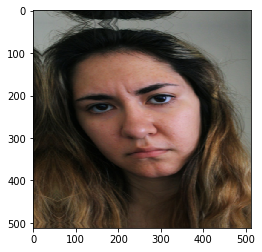

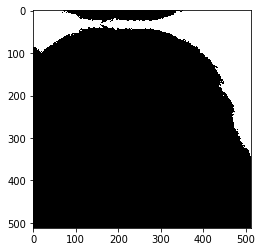

(512, 512, 3)
(512, 512, 1)


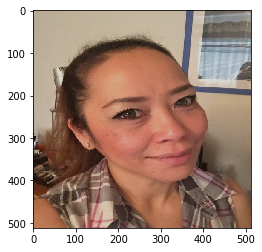

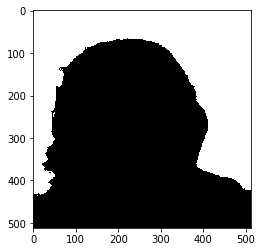

(512, 512, 3)
(512, 512, 1)


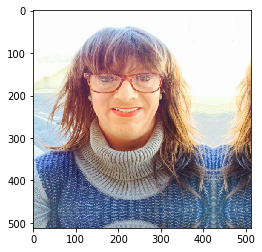

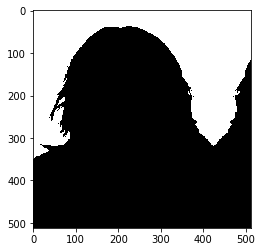

(512, 512, 3)
(512, 512, 1)


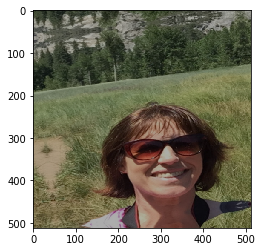

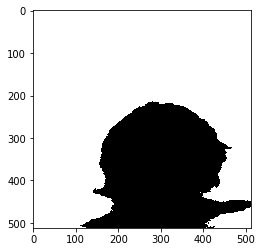

(512, 512, 3)
(512, 512, 1)


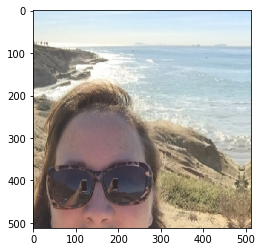

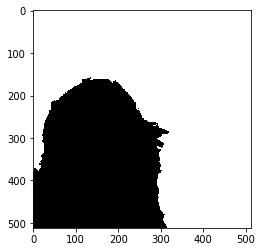

(512, 512, 3)
(512, 512, 1)


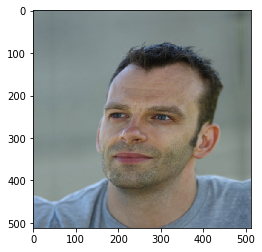

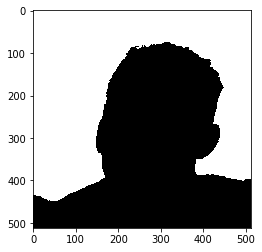

(512, 512, 3)
(512, 512, 1)


In [ ]:
a = DataGenerator(batch_size=10,shuffle=False, augmentations=AUGMENTATIONS_TRAIN)
gen_images,gen_masks = a.__getitem__(0)
max_images = 10
grid_width = 2

print()
print("-----------------------------------------")
print()
for i in range(10):
#     img = gen_images[i].astype(np.uint8)

    img = gen_images[i]
    gt = gen_masks[i]

    print(img.shape)
    print(gt.shape)
    
#     print("img dtype:")
#     print(img.dtype)
    
#     print("mask dtype:")
#     print(gt.dtype)
    
    
    plt.imshow(img)
#     print(img[200:230, 200:240])
    plt.show()

    plt.imshow(gt.squeeze(), cmap = "Greys")
#     print(gt.squeeze()[200:230, 200:240])
    plt.show()

In [33]:
# Here the two generators are instantiated to fit in the model.fit_generator()
batchSize = 4
print(sample_dir)
print(mask_dir)
print(test_sample_dir)
print(test_mask_dir)
training_generator = DataGenerator(batch_size= batchSize, augmentations=AUGMENTATIONS_TRAIN,img_size=IMG_HEIGHT, mode = "train")

validation_generator = DataGenerator(batch_size=batchSize,train_im_path = test_sample_dir ,
                                     train_mask_path=test_mask_dir,
                                     augmentations=None,
                                     img_size=IMG_HEIGHT,
                                    mode = "test")


../training/sample/
../training/mask/
../testing/sample/
../testing/mask/


In [34]:
opt = tf.keras.optimizers.Adam(lr =0.002)
model.compile(optimizer=opt, loss=bce_dice_loss, metrics=[dice_loss])

In [35]:
model = None
model = models.load_model("./weights.hdf5", custom_objects={'bce_dice_loss': bce_dice_loss,
                                                           'dice_loss': dice_loss})

In [ ]:
history = model.fit_generator(training_generator,
                    epochs=20,
                    validation_data = validation_generator,
                    callbacks=[cp],
                    verbose =1,
                    workers=8
                    )

Epoch 1/20
424/425 [============================>.] - ETA: 1s - loss: 0.0775 - dice_loss: 0.0226

/home/tomzhouyuxing/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:112: RuntimeWarning: invalid value encountered in greater
/home/tomzhouyuxing/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:113: RuntimeWarning: invalid value encountered in less



Epoch 00001: val_loss did not improve from 0.09635
425/425 [==============================] - 669s 2s/step - loss: 0.0774 - dice_loss: 0.0226 - val_loss: 0.1057 - val_dice_loss: 0.0256
Epoch 2/20
424/425 [============================>.] - ETA: 1s - loss: 0.0765 - dice_loss: 0.0220
Epoch 00002: val_loss did not improve from 0.09635
425/425 [==============================] - 665s 2s/step - loss: 0.0764 - dice_loss: 0.0220 - val_loss: 0.1176 - val_dice_loss: 0.0346
Epoch 3/20
424/425 [============================>.] - ETA: 1s - loss: 0.0749 - dice_loss: 0.0217
Epoch 00003: val_loss improved from 0.09635 to 0.09581, saving model to ./weights.hdf5
425/425 [==============================] - 666s 2s/step - loss: 0.0749 - dice_loss: 0.0217 - val_loss: 0.0958 - val_dice_loss: 0.0241
Epoch 4/20
424/425 [============================>.] - ETA: 1s - loss: 0.0767 - dice_loss: 0.0219
Epoch 00004: val_loss did not improve from 0.09581
425/425 [==============================] - 664s 2s/step - loss: 0.

## To-do
Change the dice loss to see if everything will be different.

In [37]:
model.save("./v1_maybe_overfitting.hdf5")

In [38]:
predictions = model.predict_generator(validation_generator, steps = 3) # NOTE THAT the input values should be normalized to be between 0 and 1

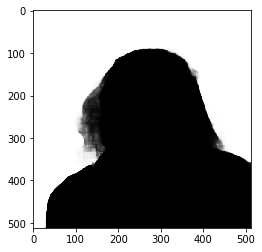

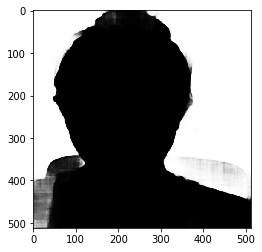

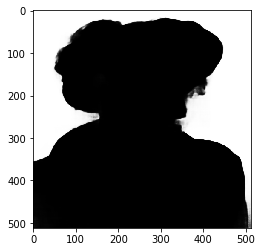

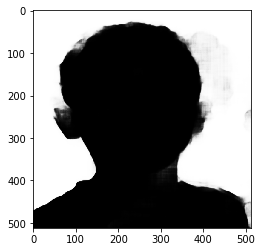

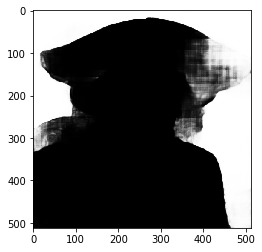

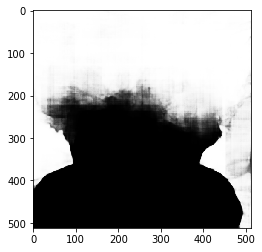

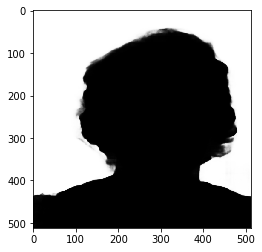

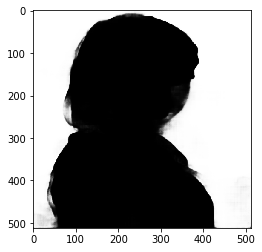

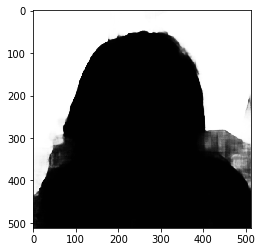

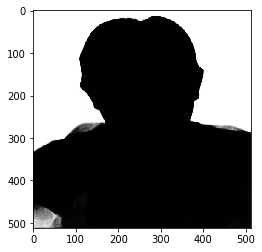

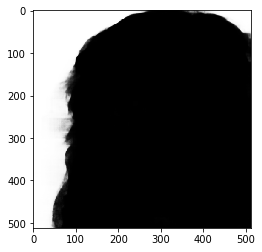

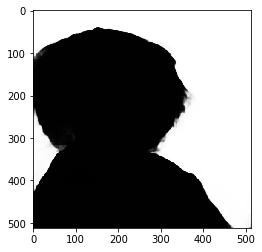

In [39]:
for i in range(predictions.shape[0]):
    img = predictions[i][:,:,0]
    img = np.trunc(img*255)
    img = img.astype(np.uint8)
    plt.imshow(img, cmap= 'Greys')
    plt.show()
#     plt.imshow(Y_train[i][:,:,0], cmap = 'Greys')
    plt.show()
    
    